In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# LSFF: generate input data coverage maps for gbd risk factors

In [2]:
## load targets
import pickle
data_prep_dir = '/ihme/homes/beatrixh/notebooks/viv_rsc/new_lsff/inputs/'

with open(data_prep_dir + 'lsff_vehicle_nutrient_pairs.pickle', 'rb') as handle:
    vehicle_nutrient_map = pickle.load(handle)
    
with open(data_prep_dir + 'lsff_country_vehicle_pairs.pickle', 'rb') as handle:
    country_vehicle_map = pickle.load(handle)

countries = [i for i in country_vehicle_map.keys() if type(i)==str]

In [3]:
input_data_path = "/home/j/Project/simulation_science/lsff/GBD 2019 input data/risk_factor_input_data.csv"
df = pd.read_csv(input_data_path)

In [4]:
df.shape

(40217, 27)

In [5]:
df.columns

Index(['Citation', 'Component', 'Subcomponent', 'Location', 'Cause', 'Risk',
       'Covariate', 'Sustainable Development Goal', 'Publication Status',
       'Provider', 'Provider URL', 'GHDX URL', 'Secondary GHDx URL',
       'Data Collection Method', 'Year Start', 'Year End', 'Sex', 'Age Start',
       'Age End', 'Age Type', 'Representativeness', 'Urbanicity Type',
       'Population Representativeness Covariates', 'Sample Size',
       'Sample Size Unit', 'Standard Error', 'Country'],
      dtype='object')

In [6]:
usecols = ['Location','Risk','Year Start','Year End','Sex','Age Start','Age End','Representativeness', 'Urbanicity Type',
       'Population Representativeness Covariates', 'Sample Size','Sample Size Unit', 'Standard Error', 'Country']
df[usecols].head()

,Location,Risk,Year Start,Year End,Sex,Age Start,Age End,Representativeness,Urbanicity Type,Population Representativeness Covariates,Sample Size,Sample Size Unit,Standard Error,Country
0,Angola,Vitamin A deficiency,1998,1998,Females,1.0,5.0,Unknown,Unknown,NaN,765.000000,people,0.300101,Angola
1,Angola,Vitamin A deficiency,1998,1998,Males,1.0,5.0,Unknown,Unknown,NaN,765.000000,people,0.293531,Angola
2,Bangladesh,Vitamin A deficiency,2002,2002,Males,5.0,10.0,Unknown,Unknown,NaN,579.000000,people,0.136488,Bangladesh
3,Bangladesh,Vitamin A deficiency,2002,2002,Females,5.0,10.0,Unknown,Unknown,NaN,579.000000,people,0.142426,Bangladesh
4,Bangladesh,Vitamin A deficiency,1999,1999,Females,15.0,20.0,Unknown,Unknown,NaN,30.336459,people,0.072998,Bangladesh


In [8]:
location_name_map = {    
    'Angola': 'Angola',
    'Bangladesh': 'Bangladesh',
    'Burkina Faso': 'Burkina Faso',
    "Côte d'Ivoire": "Côte d'Ivoire",
    'Cameroon': 'Cameroon',
    'China': 'China',
    'Democratic Republic of the Congo': 'Democratic Republic of the Congo',
    'Egypt': 'Egypt',
    'Ethiopia': 'Ethiopia',
    'Ghana': 'Ghana',
    'India': 'India',
    'Indonesia': 'Indonesia',
    'Kenya': 'Kenya',
    'Madagascar': 'Madagascar',
    'Mozambique': 'Mozambique',
    'Nepal': 'Nepal',
    'Nigeria': 'Nigeria',
    'Pakistan': 'Pakistan',
    'South Africa': 'South Africa',
    'Sudan': 'Sudan',
    'Uganda': 'Uganda',
    'United Republic of Tanzania': 'United Republic of Tanzania',
    'Viet Nam': 'Vietnam',
    'Myanmar': 'Myanmar',
    'Niger': 'Niger'
}

df['location_name'] = df.Country.map(location_name_map)

In [9]:
data_density = df.copy()
data_density['nrows'] = 1
data_density = data_density[['Risk','location_name','nrows']].groupby(['Risk','location_name']).sum().reset_index()
# data_density.rename(columns={'Location':'location_name'}, inplace=True)

In [47]:
## get shapefiles

In [10]:
import geopandas as gpd, matplotlib as mpl, matplotlib.backends.backend_pdf

In [11]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.name = world.name.astype(str)

world.loc[world.name=="Dem. Rep. Congo",'name'] = 'Democratic Republic of the Congo'
world.loc[world.name=="Tanzania",'name'] = 'United Republic of Tanzania'
world.rename(columns = {'name':'location_name'}, inplace=True)

In [12]:
assert len([i for i in data_density.location_name.unique() if i not in world.location_name.unique()])==0

In [13]:
shapefiles = world.merge(data_density, on = 'location_name', how = 'right')

In [14]:
shapefiles.head()

,pop_est,continent,location_name,iso_a3,gdp_md_est,geometry,Risk,nrows
0,53950935,Africa,United Republic of Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Iron deficiency,626
1,53950935,Africa,United Republic of Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Vitamin A deficiency,49
2,53950935,Africa,United Republic of Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Zinc deficiency,72
3,260580739,Asia,Indonesia,IDN,3028000.0,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ...",Iron deficiency,5567
4,260580739,Asia,Indonesia,IDN,3028000.0,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ...",Vitamin A deficiency,77


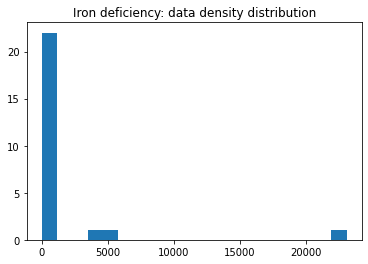

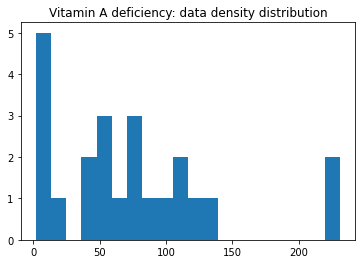

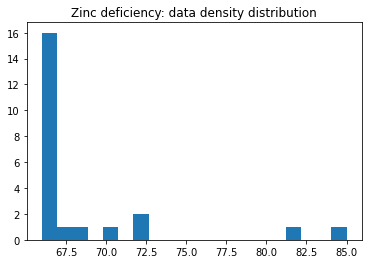

In [15]:
for i in shapefiles.Risk.unique():
    plt.title(f'{i}: data density distribution')
    plt.hist(shapefiles[shapefiles.Risk==i].nrows, bins = 20)
    plt.show()

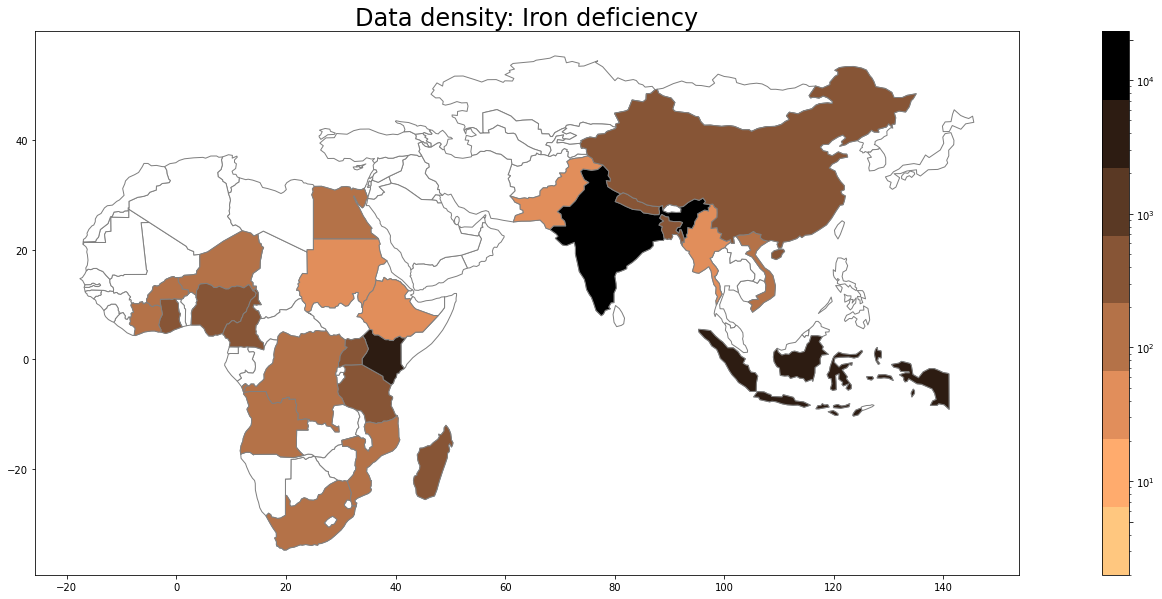

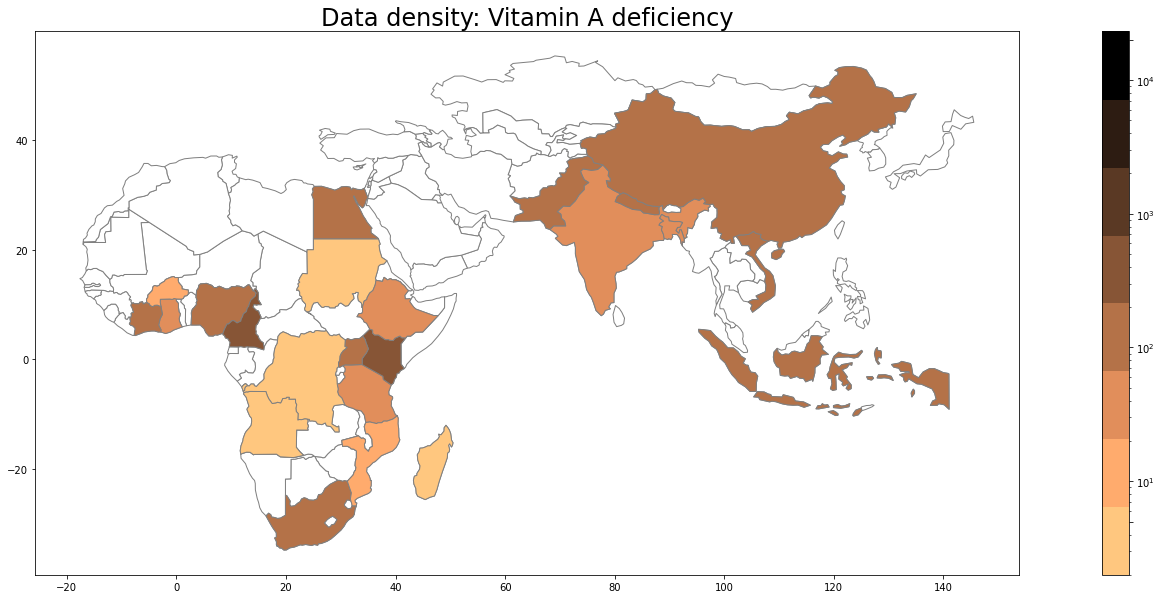

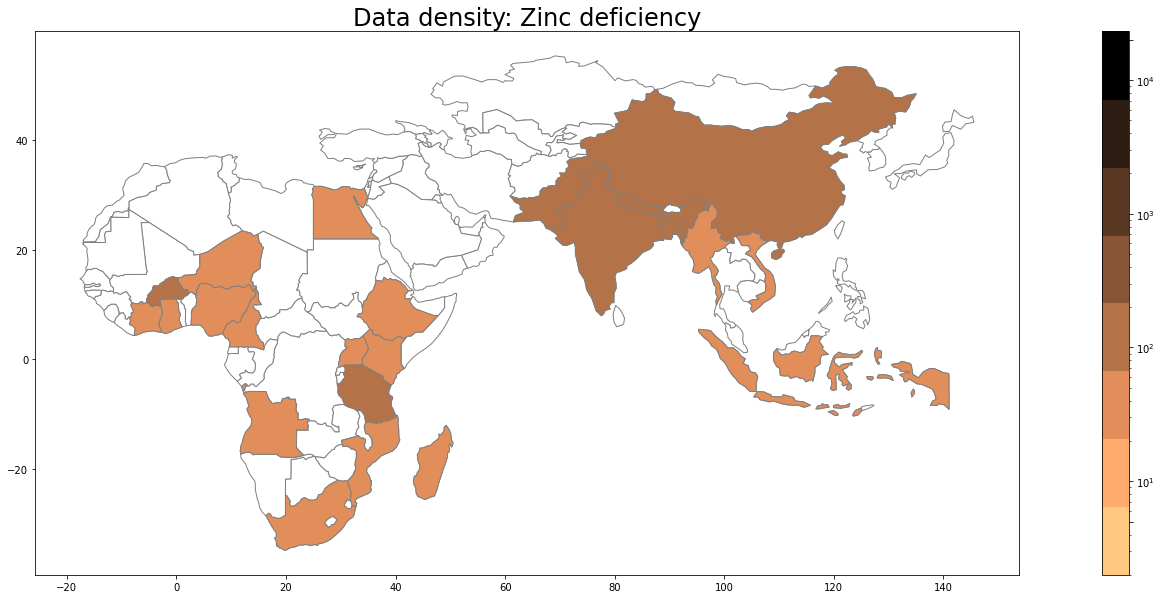

In [19]:
def map_rf_data_density(risk_factor, n_colors=8):
    fig, ax = plt.subplots(figsize=(30,10))

    ax.set_aspect('equal')
    ax.set_title(f'Data density: {risk_factor}', fontsize = 24)

    # plot country outlines
    base = world[world.continent.isin(['Africa','Asia'])].plot(ax=ax, color='white', edgecolor='gray')

    rf_df = shapefiles[shapefiles.Risk==risk_factor]
    scale_max = shapefiles.nrows.max()
    scale_min = shapefiles.nrows.min()

    # color in countries for which we have counts
    cmap = plt.cm.get_cmap('copper_r', n_colors) #colorscale, discretized to n_colors bins
    #     cmap = 'copper_r'
    #     norm = mpl.colors.Normalize(vmin=0, vmax=scale_max) #normalize color scale
    norm = mpl.colors.LogNorm(vmin=0, vmax=scale_max),
    me = rf_df.plot(ax=base,
                    column='nrows',
                    cmap=cmap,
                    norm = matplotlib.colors.LogNorm(vmin=scale_min, vmax=scale_max),
                    legend=True,
                    legend_kwds = {'ticks':[0,5,10,100,1000,10000,20000]},
                    edgecolor = 'gray')
    
save_path = '/ihme/homes/beatrixh/notebooks/viv_rsc/new_lsff/outputs/plots/gbd_risk_input_data_density_map.pdf'
pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
for rf in shapefiles.Risk.unique():
    fig =  map_rf_data_density(rf)
    pdf.savefig(fig)
pdf.close()